In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

In [7]:
def import_facebook_data(path):
  c1,c2 = np.loadtxt(path, usecols=(0,1), unpack=True,dtype=int)
  a = np.stack((c1, c2), axis= -1)
  return a 

def import_bitcoin_data(path):
  my_csv = np.genfromtxt(path, delimiter=',',dtype=int)
  c1 = my_csv[:, 0]
  c2 = my_csv[:, 1]
  a = np.stack((c1, c2), axis= -1)
  return a

def edgelist_to_mat(edg):
    size = (np.amax(edg))  
    mat = np.zeros((size+1,size+1))
    for i in range(np.shape(edg)[0]):
      a,b = edg[i]
      mat[a][b]=1
      mat[b][a]=1
    return mat

def spectralDecomp_OneIter(nodes_conn):

  def edgelist_to_mat(edg):
    size = (np.amax(edg))  
    mat = np.zeros((size+1,size+1))
    for i in range(np.shape(edg)[0]):
      a,b = edg[i]
      mat[a][b]=1
      mat[b][a]=1
    return mat

  M = edgelist_to_mat(nodes_conn)
  # G = nx.from_numpy_matrix(M)
  D = np.diag(np.sum(M, axis=1))
  L = D - M
  e, v = np.linalg.eigh(L)

  index = np.where(e > 10e-4)[0]

  a = np.where(v[:,index[0]]<=0)[0][0]
  b = np.where(v[:,index[0]]>0)[0][0]
  # print(a,b)

  graph_part = np.zeros((len(M),2))
  for i in range(len(M)):
    graph_part[i][0]=i
    graph_part[i][1]=(a if v[:,index[0]][i]<=0 else b)

  return v[:,index[0]],M,graph_part



def spectralDecomposition(nodes_connectivity_list_fb):
  out = []
  conn_lst = nodes_connectivity_list_fb

  def conductance(mat,part):
    [a,b] = np.unique(part[:,1])
    n2 = np.where(part[:,1]==b)[0]
    n1 = np.where(part[:,1]==a)[0]
    ones_n1 = np.zeros((len(mat)))
    ones_n1[n1] = 1
    ones_n2 = np.zeros((len(mat)))
    ones_n2[n2] = 1
    
    cut_v1v2 = 0
    for i in n1:
      cut_v1v2 += np.sum(np.multiply(mat[i,:],ones_n2))
    vol_v1 =0
    for i in n1:
      vol_v1 += np.sum(np.multiply(mat[i,:],ones_n1))
    vol_v2 =0
    for i in n2:
      vol_v2 += np.sum(np.multiply(mat[i,:],ones_n2))
    # print(cut_v1v2,vol_v1)
    return (cut_v1v2/(min(vol_v1,vol_v2)))

  def recursion(lst,out,conn_lst): # lst contains particular nodes of sub-graph # out is array of list partitions
    map1 = {}
    map2 = {}
    cnt = 0
    for i in lst:
        map1[cnt]=i
        map2[i]=cnt
        cnt+=1

    conn_maped_lst = []
    for i,j in conn_lst:
      if(i in map2 and j in map2):
        conn_maped_lst.append((map2[i],map2[j]))
    
    _, mapped_mat, gpart = spectralDecomp_OneIter(conn_maped_lst)
    if(conductance(mapped_mat,gpart) < 0.1):  ## 0.1 is threshold for conductance -->> hyperparameter
      a,b = np.unique(gpart[:,1])
      n2 = np.where(gpart[:,1]==b)[0]
      n1 = np.where(gpart[:,1]==a)[0]  
      l1=[]
      l2=[]
      for i in n1:
        l1.append(map1[i])
      for i in n2:
        l2.append(map1[i])

      recursion(l1,out,conn_lst)
      recursion(l2,out,conn_lst)      
    else:
      out.append(lst)
  
  def edgelist_to_mat(edg):
    size = (np.amax(edg))  
    mat = np.zeros((size+1,size+1))
    for i in range(np.shape(edg)[0]):
      a,b = edg[i]
      mat[a][b]=1
      mat[b][a]=1
    return mat
  
  org_lst = np.unique(conn_lst)
  recursion(org_lst,out,conn_lst)

  matx = edgelist_to_mat(nodes_connectivity_list_fb)
  graph_part = np.zeros((len(matx),2))
  for i in range(len(matx)):
    graph_part[i][0]=i
  
  for i in range(len(out)):
    a = np.sort(out[i])[0]
    for j in out[i]:
      graph_part[j][1]=a
  

  return graph_part


def createSortedAdjMat(gpart,nd_connlst):
  gpart1 = gpart.copy()
  matx = edgelist_to_mat(nd_connlst)
  fried_vec,_,__ = spectralDecomp_OneIter(nd_connlst)
  gpart = np.c_[gpart,fried_vec]
  gpart = gpart[np.argsort(gpart[:,-1])] # sort acc to fried vec
  gpart = gpart[np.argsort(gpart[:,1])]  # sort acc to partition
  print("plotting associated sorted graph")
  sort_mat = np.zeros_like(matx)
  for i1,i2 in enumerate(gpart[:,0]):
    for j1,j2 in enumerate(gpart[:,0]):
      sort_mat[i1][j1] = matx[int(i2)][int(j2)]
  
  plt.figure(figsize=(10,10))
  plt.imshow(sort_mat)
  plt.show()
  print("plotting graph")
  G = nx.from_numpy_matrix(matx)
  nx.draw(G,node_color=gpart1[:,1])

  return sort_mat


def louvain_one_iter(nodes_connectivity_list_fb):
  def edgelist_to_mat(edg):
    size = (np.amax(edg))  
    mat = np.zeros((size+1,size+1))
    for i in range(np.shape(edg)[0]):
      a,b = edg[i]
      mat[a][b]=1
      mat[b][a]=1
    return mat
  nodes_conn = nodes_connectivity_list_fb
  nodes = np.unique(nodes_conn)

  adjmat = edgelist_to_mat(nodes_conn)
  m = np.sum(adjmat)/2

  node_to_comm = {} # particular node belonging to which community
  for i in range(len(adjmat[0])):
    node_to_comm[i] = i

  nd_neighb = {}  #neighbor list of each node ,, will never change
  for i in nodes:
    nd_neighb[i] = np.where(adjmat[i]==1)[0]
  
  nd_deg = np.zeros((len(adjmat),1))
  nd_deg = np.sum(adjmat,axis=-1)
  degofcomm = nd_deg
  itera=0
  while(True):
    delq_g = 0
    nd_g = 0
    c1_g = 0
    c2_g = 0

    for i in nodes:
      delq_i_max = 0
      com1 = node_to_comm[i]
      c2_i = 0

      d1 = degofcomm[com1]
      ki = nd_deg[i]
      neighnode_i = nd_neighb[i]

      kiin1=0
      nodeneighb_comm = []
      for l in neighnode_i :
        comnumb = node_to_comm[l]
        nodeneighb_comm.append(comnumb)
        if(comnumb==com1):
          kiin1+=1
          
      nodeneighb_comm = np.unique(nodeneighb_comm)
      
      for j in nodeneighb_comm:
        
        # com2 = node_to_comm[j]
        com2 = j
        d2 = degofcomm[com2]

        # kiin1=0
        kiin2=0
        for l in neighnode_i:
          comnumb = node_to_comm[l]
          if(comnumb == j):
            kiin2+=1
            
        delq_i = (ki*(d1-d2))/(2*m) + (kiin2-kiin1) - ki**2/(2*m)
        
        if(delq_i > delq_i_max):
          delq_i_max = delq_i
          c2_i = com2
      if(delq_i_max > 0.0001 ):
        # print(delq_i_max)
        node_to_comm[i]=c2_i
        degofcomm[c2_i] += nd_deg[i]
        degofcomm[com1] -= nd_deg[i]
      
      if(delq_i_max > delq_g):
          delq_g = delq_i_max
    
    if(delq_g <= 0.0001 ):
      break
  gpart = np.zeros((len(adjmat),2))
  for i in range(len(adjmat)):
    gpart[i][0]=i
    gpart[i][1]= node_to_comm[i]
  
  return gpart

In [ ]:
graph_partition_louvain_btc = louvain_one_iter(nodes_connectivity_list_btc)
print(len(np.unique(graph_partition_louvain_btc[:,1])))

In [ ]:
graph_partition_louvain_btc = louvain_one_iter(nodes_connectivity_list_btc)
len(np.unique(graph_partition_louvain_btc[:,1])
# nx.draw(G_btc,node_color=graph_partition_btc[:,1])

In [5]:
nodes_connectivity_list_fb = import_facebook_data("/content/facebook_combined.txt")
# nodes_connectivity_list_btc = import_bitcoin_data("/content/soc-sign-bitcoinotc.csv")

In [12]:
##Q1(facebook and bitcoin)
fvec_fb, adjmat_fb, gpart_fb = spectralDecomp_OneIter(nodes_connectivity_list_fb)
# fvec_btc, adjmat_btc, gpart_btc = spectralDecomp_OneIter(nodes_connectivity_list_btc)
G_fb = nx.from_numpy_matrix(adjmat_fb)
# G_btc = nx.from_numpy_matrix(adjmat_btc)
#

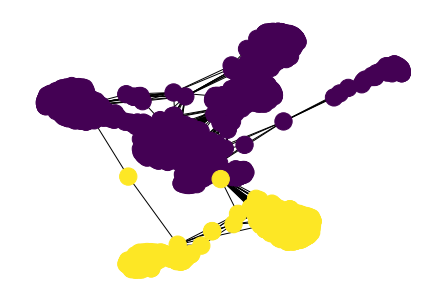

In [ ]:
nx.draw(G_fb,node_color=gpart_fb[:,1])

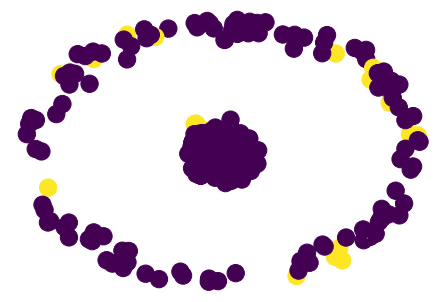

In [ ]:
nx.draw(G_btc,node_color=gpart_btc[:,1])

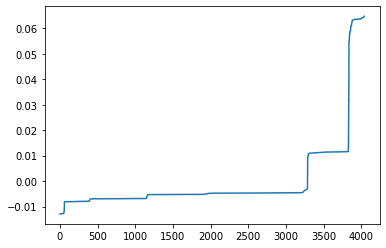

In [ ]:
plt.plot(range(len(fvec_fb)),np.sort(fvec_fb))
plt.show()

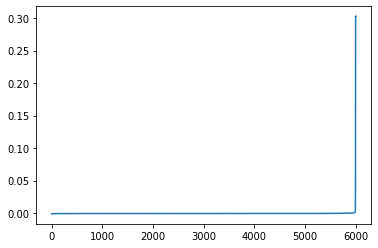

In [ ]:
plt.plot(range(len(fvec_btc)),np.sort(fvec_btc))
plt.show()

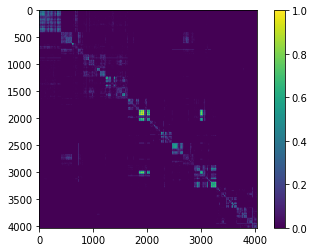

In [ ]:
# fvec_fb, adjmat_fb, gpart_fb
gpart = gpart_fb.copy()
fvec = fvec_fb.copy()
sort_mat_fb = np.zeros_like(adjmat_fb)
# gpart1 = gpart.copy()
gpart = np.c_[gpart,fvec]
gpart = gpart[np.argsort(gpart[:,-1])] # sort acc to fried vec
gpart = gpart[np.argsort(gpart[:,1])]  # sort acc to partition

for i1,i2 in enumerate(gpart[:,0]):
  for j1,j2 in enumerate(gpart[:,0]):
    # print(i1,j1,i2,j2)
    sort_mat_fb[i1][j1] = adjmat_fb[int(i2)][int(j2)]
plt.figure(figsize=(10,10))
plt.imshow(sort_mat_fb)
plt.colorbar()
plt.show()

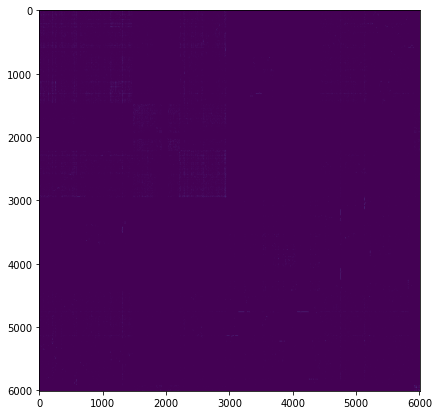

In [ ]:
# fvec_fb, adjmat_fb, gpart_fb
gpart = gpart_btc.copy()
fvec = fvec_btc.copy()
sort_mat_btc = np.zeros_like(adjmat_btc)
# gpart1 = gpart.copy()
gpart = np.c_[gpart,fvec]
gpart = gpart[np.argsort(gpart[:,-1])] # sort acc to fried vec
gpart = gpart[np.argsort(gpart[:,1])]  # sort acc to partition

for i1,i2 in enumerate(gpart[:,0]):
  for j1,j2 in enumerate(gpart[:,0]):
    # print(i1,j1,i2,j2)
    sort_mat_btc[i1][j1] = adjmat_btc[int(i2)][int(j2)]
plt.figure(figsize=(7,7))
plt.imshow(sort_mat_btc)
plt.show()

In [ ]:
graph_partition_fb = spectralDecomposition(nodes_connectivity_list_fb)

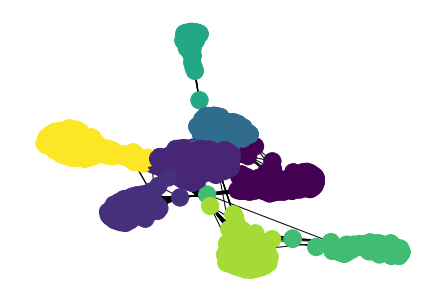

In [ ]:
nx.draw(G_fb,node_color=graph_partition_fb[:,1])

In [ ]:
np.unique(graph_partition_fb[:,1])

array([  0., 107., 136., 348., 594., 686., 857., 990.])

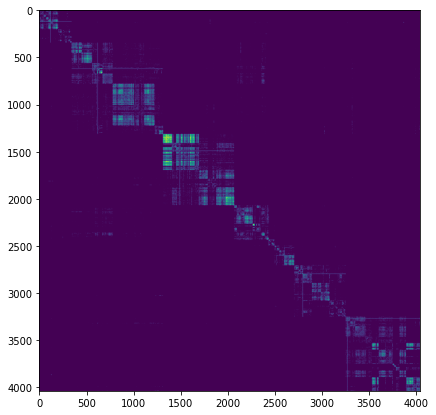

In [ ]:
gpart = graph_partition_fb.copy()
fvec = fvec_fb.copy()
sort_mat_fb = np.zeros_like(adjmat_fb)
# gpart1 = gpart.copy()
gpart = np.c_[gpart,fvec]
gpart = gpart[np.argsort(gpart[:,-1])] # sort acc to fried vec
gpart = gpart[np.argsort(gpart[:,1])]  # sort acc to partition

for i1,i2 in enumerate(gpart[:,0]):
  for j1,j2 in enumerate(gpart[:,0]):
    # print(i1,j1,i2,j2)
    sort_mat_fb[i1][j1] = adjmat_fb[int(i2)][int(j2)]
plt.figure(figsize=(7,7))
plt.imshow(sort_mat_fb)
plt.show()

In [ ]:
graph_partition_btc = spectralDecomposition(nodes_connectivity_list_btc)

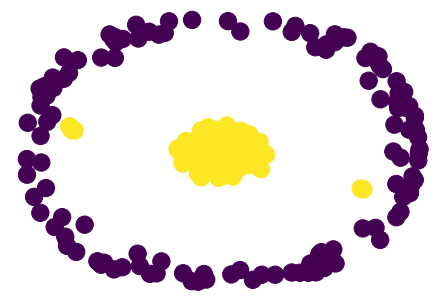

In [ ]:
nx.draw(G_btc,node_color=graph_partition_btc[:,1])

In [ ]:
np.unique(graph_partition_btc[:,1])

array([0., 1.])

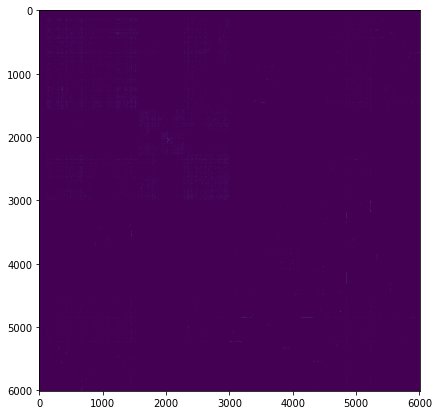

In [ ]:
# fvec_fb, adjmat_fb, gpart_fb
gpart = graph_partition_btc.copy()
fvec = fvec_btc.copy()
sort_mat_btc = np.zeros_like(adjmat_btc)
# gpart1 = gpart.copy()
gpart = np.c_[gpart,fvec]
gpart = gpart[np.argsort(gpart[:,-1])] # sort acc to fried vec
gpart = gpart[np.argsort(gpart[:,1])]  # sort acc to partition

for i1,i2 in enumerate(gpart[:,0]):
  for j1,j2 in enumerate(gpart[:,0]):
    # print(i1,j1,i2,j2)
    sort_mat_btc[i1][j1] = adjmat_btc[int(i2)][int(j2)]
plt.figure(figsize=(7,7))
plt.imshow(sort_mat_btc)
plt.show()

In [9]:
graph_partition_louvain_fb = louvain_one_iter(nodes_connectivity_list_fb)
print(np.unique(graph_partition_louvain_fb[:,1]))
print(len(np.unique(graph_partition_louvain_fb[:,1])))

[  11.   42.   57.   69.   95.  135.  151.  152.  174.  179.  189.  192.
  201.  241.  256.  278.  282.  351.  375.  382.  505.  612.  642.  650.
  656.  692.  702.  757.  831.  852.  865.  877.  882.  895.  911.  972.
  974. 1016. 1034. 1044. 1069. 1111. 1178. 1208. 1224. 1240. 1245. 1253.
 1265. 1417. 1586. 1627. 1657. 1698. 1760. 1771. 1775. 1829. 1856. 1892.
 1905. 1952. 2079. 2113. 2167. 2182. 2204. 2205. 2219. 2401. 2424. 2435.
 2493. 2536. 2565. 2584. 2595. 2613. 2721. 2771. 2792. 2801. 2814. 2817.
 2899. 2902. 2917. 2990. 3012. 3099. 3122. 3194. 3244. 3262. 3311. 3336.
 3407. 3413. 3543. 3581. 3585. 3598. 3641. 3657. 3668. 3669. 3675. 3676.
 3699. 3742. 3787. 3792. 3846. 3885. 3925. 4007. 4012. 4018. 4029.]
119


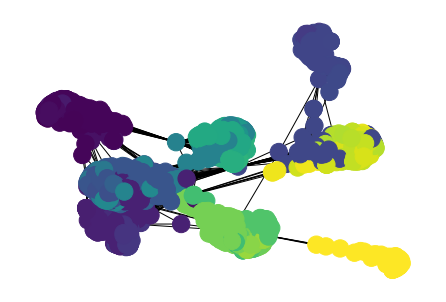

In [13]:
nx.draw(G_fb,node_color=graph_partition_louvain_fb[:,1])

In [ ]:
graph_partition_louvain_btc = louvain_one_iter(nodes_connectivity_list_btc)
len(np.unique(graph_partition_louvain_btc[:,1])
# nx.draw(G_btc,node_color=graph_partition_btc[:,1])

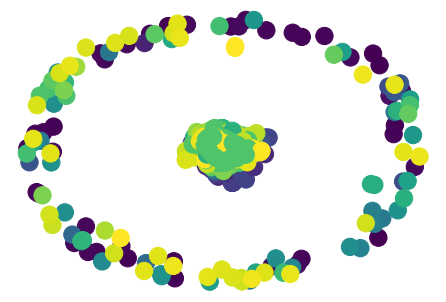

In [ ]:
nx.draw(G_btc,node_color=graph_partition_louvain_btc[:,1])

In [ ]:
if __name__ == "__main__":

    ############ Answer qn 1-4 for facebook data ##############
    # Import facebook_combined.txt
    # nodes_connectivity_list is a nx2 numpy array, where every row 
    # is a edge connecting i<->j (entry in the first column is node i, 
    # entry in the second column is node j)
    # Each row represents a unique edge. Hence, any repetitions in data must be cleaned away.
    nodes_connectivity_list_fb = import_facebook_data("/content/facebook_combined.txt")


    # This is for question no. 1
    # fielder_vec    : n-length numpy array. (n being number of nodes in the network)
    # adj_mat        : nxn adjacency matrix of the graph
    # graph_partition: graph_partitition is a nx2 numpy array where the first column consists of all
    #                  nodes in the network and the second column lists their community id (starting from 0)
    #                  Follow the convention that the community id is equal to the lowest nodeID in that community.
    # fielder_vec_fb, adj_mat_fb, graph_partition_fb = spectralDecomp_OneIter(nodes_connectivity_list_fb)

    # This is for question no. 2. Use the function 
    # written for question no.1 iteratetively within this function.
    # graph_partition is a nx2 numpy array, as before. It now contains all the community id's that you have
    # identified as part of question 2. The naming convention for the community id is as before.
    # graph_partition_fb = spectralDecomposition(nodes_connectivity_list_fb)

    # # This is for question no. 3
    # # Create the sorted adjacency matrix of the entire graph. You will need the identified communities from
    # # question 3 (in the form of the nx2 numpy array graph_partition) and the nodes_connectivity_list. The
    # # adjacency matrix is to be sorted in an increasing order of communitites.
    # clustered_adj_mat_fb = createSortedAdjMat(graph_partition_fb, nodes_connectivity_list_fb)

    # # This is for question no. 4
    # # run one iteration of louvain algorithm and return the resulting graph_partition. The description of
    # # graph_partition vector is as before.
    # graph_partition_louvain_fb = louvain_one_iter(nodes_connectivity_list_fb)


    # ############ Answer qn 1-4 for bitcoin data #################################################
    # # Import soc-sign-bitcoinotc.csv
    nodes_connectivity_list_btc = import_bitcoin_data("/content/soc-sign-bitcoinotc.csv")

    # # Question 1
    # fielder_vec_btc, adj_mat_btc, graph_partition_btc = spectralDecomp_OneIter(nodes_connectivity_list_btc)

    # # Question 2
    # graph_partition_btc = spectralDecomposition(nodes_connectivity_list_btc)

    # # Question 3
    # clustered_adj_mat_btc = createSortedAdjMat(graph_partition_btc, nodes_connectivity_list_btc)

    # # Question 4
    # graph_partition_louvain_btc = louvain_one_iter(nodes_connectivity_list_btc)
